# CWRU Experiments
## Imports

In [1]:
import pandas as pd
import numpy as np

import lib.transformers as tf
from sklearn.pipeline import Pipeline

from lib.models import Ganomaly1d, Ganomaly2d, GanomalyFE, GanomalyNet
from lib.visualization import GANomalyBoard, rename_tensorboard_key

from skorch.callbacks import PassthroughScoring, ProgressBar
import torch

from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
import tensorflow

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from lib.others import create_dataset

In [2]:
cwruData0 = pd.read_parquet('data/cwru0.parquet')
cwruData1 = pd.read_parquet('data/cwru1.parquet')

cwruData = pd.concat([cwruData0, cwruData1])

## Settings

In [3]:
torch.manual_seed(0)

## Creating Datasets

In [4]:
normal_features, normal_labels = create_dataset(cwruData, feature_columns = ['fanEndData', 'driveEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Normal Baseline'], sampleRate = [12000])
normal_features_train, normal_features_test, normal_labels_train, normal_labels_test = train_test_split(normal_features, normal_labels, train_size = 400, test_size= 451, random_state = 0)

ball_features, ball_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Ball Fault'], sampleRate = [12000])
inner_features, inner_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Inner Race Fault'], sampleRate = [12000])
outer_features, outer_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Outer Race Fault'], sampleRate = [12000])


labels_test = pd.concat([ball_labels, inner_labels, outer_labels, normal_labels_test])
features_test = pd.concat([ball_features, inner_features, outer_features, normal_features_test])

normal_features_test = np.array(normal_features_test.to_list())
normal_features_train = np.array(normal_features_train.to_list())

## Initializing Model(s)

In [5]:
def build_model(model, isize, max_epochs, directory, plot_type, plot_shape, n_samples, plot_latent_shape, needs_feature_engineering = False, ngpu = 0, nz = 600, ndf = 64, ngf = 64, nc = 1, batch_size = 16, lr = 0.0001, beta1 = 0.5, beta2 = 0.999, workers = 2):
    
    if not needs_feature_engineering:
        output_model = GanomalyNet(
            model,
            module__isize = isize,
            module__nz=nz,
            module__ndf=ndf,
            module__ngf=ngf,
            module__nc=nc,
            module__ngpu=ngpu,
            module__w_app = 30,
            module__w_lambda = 30/31,

            device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu',

            criterion=torch.nn.BCELoss,

            optimizer_gen=torch.optim.Adam,
            optimizer_gen__lr=lr,
            optimizer_gen__betas=(beta1, beta2),

            optimizer_dis=torch.optim.Adam,
            optimizer_dis__lr=lr,
            optimizer_dis__betas=(beta1, beta2),

            batch_size=batch_size,
            max_epochs=max_epochs,

            train_split=False,  # not implemented
            iterator_train__shuffle=True,
            iterator_train__num_workers=workers,
            iterator_valid__num_workers=workers,

            callbacks=[
                PassthroughScoring('loss_dis', on_train=True),
                PassthroughScoring('loss_gen', on_train=True),
                PassthroughScoring('loss_gen_fra', on_train=True),
                PassthroughScoring('loss_gen_app', on_train=True),
                PassthroughScoring('loss_gen_lat', on_train=True),
                GANomalyBoard(SummaryWriter(log_dir= 'runs/' + directory), key_mapper = rename_tensorboard_key, close_after_train = False, plot_type = plot_type, plot_shape = plot_shape, n_samples = n_samples, plot_latent_shape = plot_latent_shape)
            ]
        )
    else:
            output_model = GanomalyNet(
            model,
            module__isize = isize,
            module__ngpu=ngpu,

            device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu',

            criterion=torch.nn.BCELoss,

            optimizer_gen=torch.optim.Adam,
            optimizer_gen__lr=lr,
            optimizer_gen__betas=(beta1, beta2),

            optimizer_dis=torch.optim.Adam,
            optimizer_dis__lr=lr,
            optimizer_dis__betas=(beta1, beta2),

            batch_size=batch_size,
            max_epochs=max_epochs,

            train_split=False,  # not implemented
            iterator_train__shuffle=True,
            iterator_train__num_workers=workers,
            iterator_valid__num_workers=workers,

            callbacks=[
                PassthroughScoring('loss_dis', on_train=True),
                PassthroughScoring('loss_gen', on_train=True),
                PassthroughScoring('loss_gen_fra', on_train=True),
                PassthroughScoring('loss_gen_app', on_train=True),
                PassthroughScoring('loss_gen_lat', on_train=True),
                GANomalyBoard(SummaryWriter(log_dir= 'runs/' + directory), key_mapper = rename_tensorboard_key, close_after_train = False, plot_type = plot_type, plot_shape = plot_shape, n_samples = n_samples, plot_latent_shape = plot_latent_shape)
            ]
        )
    
    return output_model

## Data Preparation
Building a pipeline of custom transformers to fetch and preprocess CWRU data.

In [6]:
max_epochs = 10

ganomaly_timeseries = build_model(Ganomaly1d, 3136, max_epochs, 'timeseries444', plot_type = 'lineplot', plot_shape = 3136, plot_latent_shape =600, n_samples = 4)
ganomaly_stacked_ts = build_model(Ganomaly2d, 56, max_epochs, 'stacked_timeseries444', plot_type = 'lineplot', plot_shape = 3136, plot_latent_shape =600, n_samples = 4)
ganomaly_fft = build_model(Ganomaly1d, 1568, max_epochs, 'fourier_transform444', plot_type = 'lineplot', plot_shape = 1568, plot_latent_shape =600, n_samples = 4)
ganomaly_stft = build_model(Ganomaly2d, 56, max_epochs, 'short_term_fourier444', plot_type = 'image', plot_shape = 56, plot_latent_shape =600, n_samples = 36)
ganomaly_fe = build_model(GanomalyFE, 4, max_epochs, 'feature_extraction444', needs_feature_engineering = True, plot_type = 'barplot', plot_shape = 16, n_samples = 4, plot_latent_shape = 32)

model_timeseries = \
Pipeline(steps=[
                ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper', tf.ArrayReshaper((1, 3136))),
                ('Model', ganomaly_timeseries)
               ])

model_stacked_ts = \
Pipeline(steps=[
                ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper', tf.ArrayReshaper((1, 56, 56))),
                ('Model', ganomaly_stacked_ts)
               ])

model_fe = \
Pipeline(steps=[
                ('FeatureExtractor', tf.FeatureExtractor(axis = 1)),
                ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper', tf.ArrayReshaper((1, 4, 4))),
                ('Model', ganomaly_fe)
               ])

model_stft = \
Pipeline(steps=[
                ('ArraySTFT', tf.ArraySTFT()),
                ('ArrayReshaper', tf.ArrayReshaper((3136))),
                ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper2', tf.ArrayReshaper((1, 56, 56))),
                ('Model', ganomaly_stft)
               ])

model_fft = \
Pipeline(steps=[
                ('ArrayFFT', tf.ArrayFFT()),
                ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper2', tf.ArrayReshaper((1, 1568))),
                ('Model', ganomaly_fft)
               ])

model_timeseries.fit(normal_features_train)
model_stacked_ts.fit(normal_features_train)
model_fe.fit(normal_features_train)
model_stft.fit(normal_features_train)
model_fft.fit(normal_features_train)

  epoch    loss_dis    loss_gen    loss_gen_app    loss_gen_fra    loss_gen_lat    train_loss      dur
-------  ----------  ----------  --------------  --------------  --------------  ------------  -------
      1      0.6009     11.5942          0.3236          0.8026          1.0831       12.1951  46.0839
      2      0.3313      6.0910          0.1620          0.8000          0.4307        6.4223  49.0566
      3      0.2114      5.0899          0.1351          0.8010          0.2367        5.3013  43.3870
      4      0.1452      4.7806          0.1272          0.8017          0.1643        4.9258  43.7593
      5      0.1244      4.4607          0.1175          0.8018          0.1353        4.5851  43.4011
      6      0.1098      4.2106          0.1094          0.8035          0.1237        4.3205  42.6307
      7      0.0867      4.0282          0.1037          0.8022          0.1139        4.1149  33.8633
      8      0.0824      3.8797          0.0991          0.7986          

Pipeline(steps=[('ArrayFFT', ArrayFFT()), ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper2', ArrayReshaper(shape=(1, 1568))),
                ('Model',
                 <class 'lib.models.GanomalyNet'>[initialized](
  module_=Ganomaly1d(
    (l_fra): BCELoss()
    (l_app): L1Loss()
    (l_dis): L1Loss()
    (discriminator): DiscriminatorNet1d(
      (features): Sequential(
        (0): Conv1d(1, 64, kernel_size=(16,), stride=(8,), pa...
          (pyramid-relu-128): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-128-256-convt): Conv1d(128, 256, kernel_size=(16,), stride=(4,), bias=False)
          (pyramid-256-batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-relu-256): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-256-1-convt): Conv1d(256, 600, kernel_size=(9,), stride=(1,), bias=False)
        )
      )
    )
  ),
))])

# GridSearchCV

In [7]:
search_parameters = {
    'module_w_fra': list(range(0, 101, 10)),
    'module_w_app': list(range(0, 101, 10)),
    'module_w_lat': list(range(0, 101, 10)),
}

In [8]:
#ganomaly_gs = GridSearchCV(ganomaly, search_parameters, refit=False, cv=4)

In [9]:
#ganomaly_gs.fit(train)

## Training Visualization (best parameters)
Adding a TensorBoard for the visualization of the training.

In [10]:
import matplotlib.pyplot as plt

In [11]:
features_test = np.array(features_test.tolist())
predictions = model_fe.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

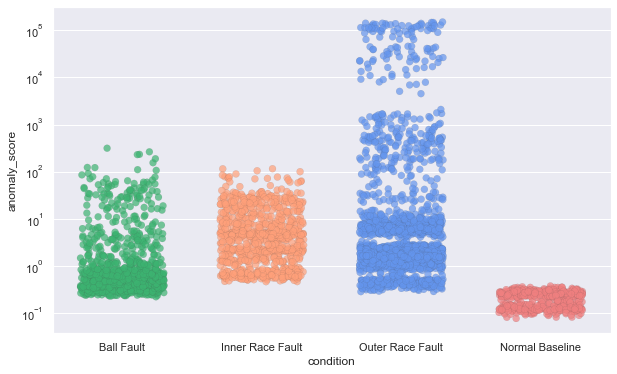

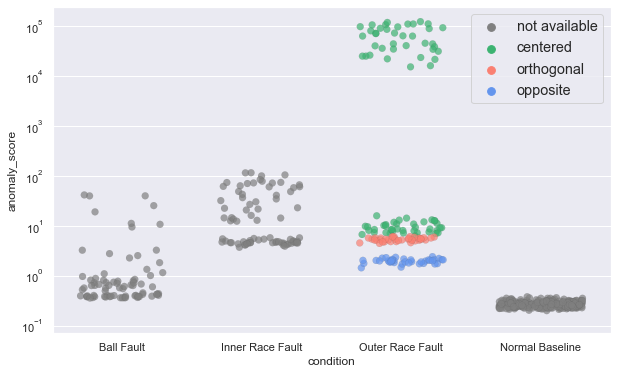

In [12]:
import seaborn as sns

sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

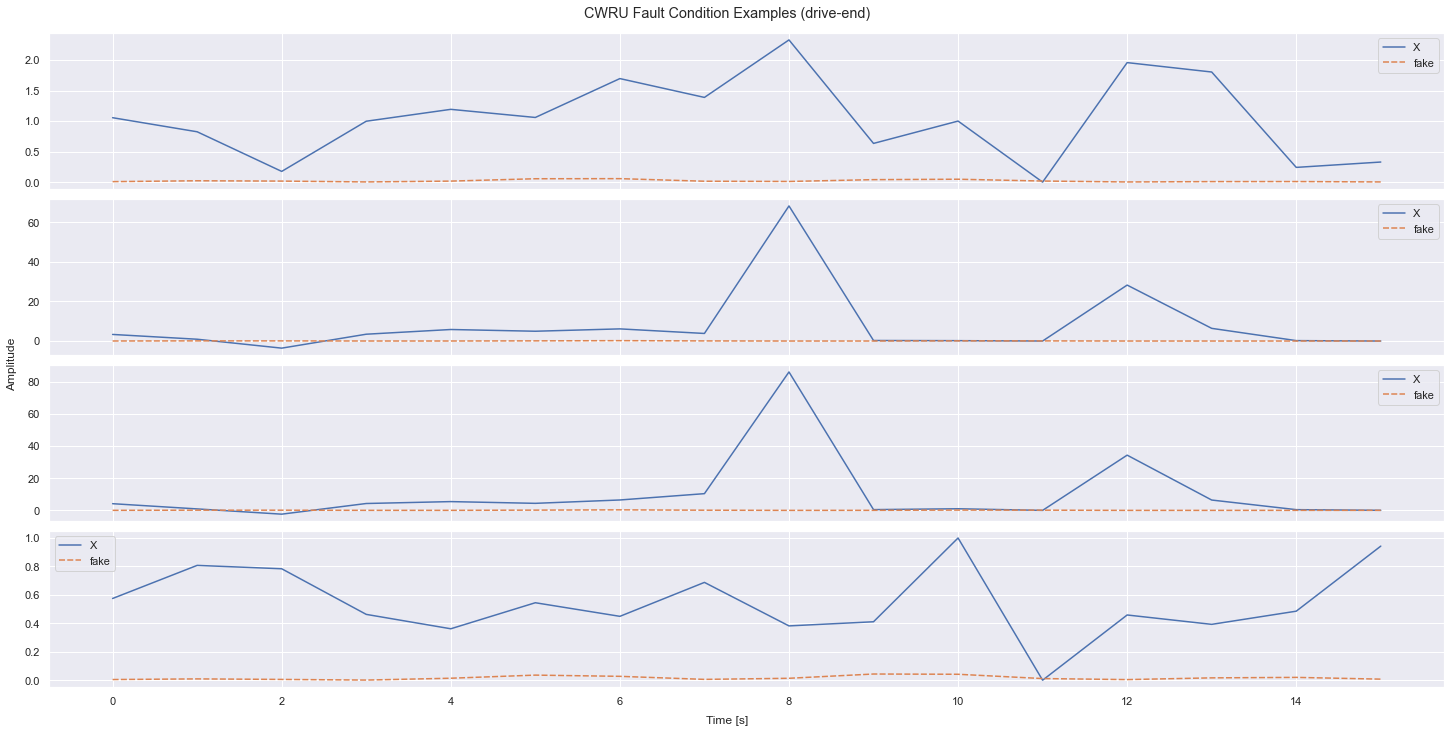

In [13]:
import matplotlib.gridspec as gridspec

first_line = 'X'
second_line = 'fake'

sns.set(rc={'figure.figsize':(20, 10)})
#sns.set_style("whitegrid")
sns.set_context('notebook')


conditionFigure = plt.figure(constrained_layout=True)
cfSpec = gridspec.GridSpec(ncols=1, nrows=4, figure=conditionFigure)
conditionFigureAxis0 = conditionFigure.add_subplot(cfSpec[0, 0])
conditionFigureAxis1 = conditionFigure.add_subplot(cfSpec[1, 0])
conditionFigureAxis2 = conditionFigure.add_subplot(cfSpec[2, 0])
conditionFigureAxis3 = conditionFigure.add_subplot(cfSpec[3, 0])

#pyplot.xlabel('Time [s]')
#pyplot.ylabel('Amplitude')


ball_fault =\
pd.DataFrame(
    [result[result['condition'] == 'Ball Fault'].iloc[0, :][first_line],
     result[result['condition'] == 'Ball Fault'].iloc[0, :][second_line]]
).T.rename({0: first_line, 1: second_line}, axis = 1)
p0 = sns.lineplot(data = ball_fault, ax = conditionFigureAxis0)
p0.set(xticklabels=[]) 

inner_race_fault =\
pd.DataFrame(
    [result[result['condition'] == 'Inner Race Fault'].iloc[0, :][first_line],
     result[result['condition'] == 'Inner Race Fault'].iloc[0, :][second_line]]
).T.rename({0: first_line, 1: second_line}, axis = 1)
p1 = sns.lineplot(data = inner_race_fault, ax = conditionFigureAxis1)
p1.set(xticklabels=[]) 

outer_race_fault =\
pd.DataFrame(
    [result[result['condition'] == 'Outer Race Fault'].iloc[0, :][first_line],
     result[result['condition'] == 'Outer Race Fault'].iloc[0, :][second_line]]
).T.rename({0: first_line, 1: second_line}, axis = 1)
p2 = sns.lineplot(data = outer_race_fault, ax = conditionFigureAxis2)
p2.set(xticklabels=[]) 

normal_baseline =\
pd.DataFrame(
    [result[result['condition'] == 'Normal Baseline'].iloc[0, :][first_line],
     result[result['condition'] == 'Normal Baseline'].iloc[0, :][second_line]]
).T.rename({0: first_line, 1: second_line}, axis = 1)
sns.lineplot(data = normal_baseline, ax = conditionFigureAxis3);

conditionFigureAxis3.set_xlabel('.', color=(0, 0, 0, 0))
conditionFigureAxis3.set_ylabel('.', color=(0, 0, 0, 0))

conditionFigure.text(0.5, 0, 'Time [s]', ha='center')
conditionFigure.text(0, 0.5, 'Amplitude', va='center', rotation='vertical')
conditionFigure.suptitle("CWRU Fault Condition Examples (drive-end)");

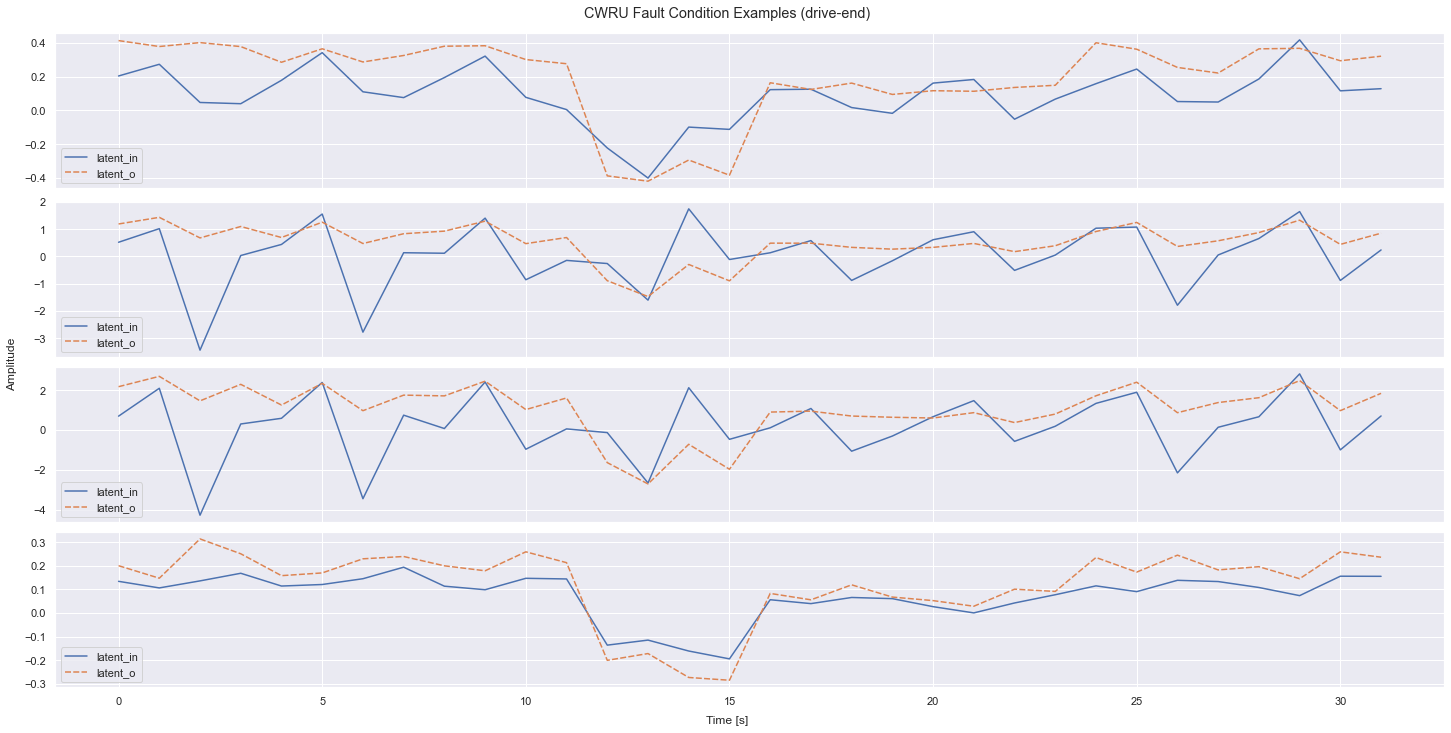

In [14]:
import matplotlib.gridspec as gridspec

first_line = 'latent_in'
second_line = 'latent_o'

sns.set(rc={'figure.figsize':(20, 10)})
#sns.set_style("whitegrid")
sns.set_context('notebook')


conditionFigure = plt.figure(constrained_layout=True)
cfSpec = gridspec.GridSpec(ncols=1, nrows=4, figure=conditionFigure)
conditionFigureAxis0 = conditionFigure.add_subplot(cfSpec[0, 0])
conditionFigureAxis1 = conditionFigure.add_subplot(cfSpec[1, 0])
conditionFigureAxis2 = conditionFigure.add_subplot(cfSpec[2, 0])
conditionFigureAxis3 = conditionFigure.add_subplot(cfSpec[3, 0])

#pyplot.xlabel('Time [s]')
#pyplot.ylabel('Amplitude')


ball_fault =\
pd.DataFrame(
    [result[result['condition'] == 'Ball Fault'].iloc[0, :][first_line],
     result[result['condition'] == 'Ball Fault'].iloc[0, :][second_line]]
).T.rename({0: first_line, 1: second_line}, axis = 1)
p0 = sns.lineplot(data = ball_fault, ax = conditionFigureAxis0)
p0.set(xticklabels=[]) 

inner_race_fault =\
pd.DataFrame(
    [result[result['condition'] == 'Inner Race Fault'].iloc[0, :][first_line],
     result[result['condition'] == 'Inner Race Fault'].iloc[0, :][second_line]]
).T.rename({0: first_line, 1: second_line}, axis = 1)
p1 = sns.lineplot(data = inner_race_fault, ax = conditionFigureAxis1)
p1.set(xticklabels=[]) 

outer_race_fault =\
pd.DataFrame(
    [result[result['condition'] == 'Outer Race Fault'].iloc[0, :][first_line],
     result[result['condition'] == 'Outer Race Fault'].iloc[0, :][second_line]]
).T.rename({0: first_line, 1: second_line}, axis = 1)
p2 = sns.lineplot(data = outer_race_fault, ax = conditionFigureAxis2)
p2.set(xticklabels=[]) 

normal_baseline =\
pd.DataFrame(
    [result[result['condition'] == 'Normal Baseline'].iloc[0, :][first_line],
     result[result['condition'] == 'Normal Baseline'].iloc[0, :][second_line]]
).T.rename({0: first_line, 1: second_line}, axis = 1)
sns.lineplot(data = normal_baseline, ax = conditionFigureAxis3);

conditionFigureAxis3.set_xlabel('.', color=(0, 0, 0, 0))
conditionFigureAxis3.set_ylabel('.', color=(0, 0, 0, 0))

conditionFigure.text(0.5, 0, 'Time [s]', ha='center')
conditionFigure.text(0, 0.5, 'Amplitude', va='center', rotation='vertical')
conditionFigure.suptitle("CWRU Fault Condition Examples (drive-end)");